## PART III : OCTMNIST Classification 


### Loading required Libraries

In [30]:
import torch
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, random_split
from medmnist import OCTMNIST
from medmnist.dataset import OCTMNIST
import os
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from sklearn.metrics import confusion_matrix, precision_recall_fscore_support, accuracy_score
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")

### Transforming the data into required format and splitting it for validation and training 

In [2]:
root_dir = './data/octmnist'
os.makedirs(root_dir, exist_ok=True)

# Define transformations
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))  # Normalize to range [0, 1]
])

batch_size = 4

# Download and preprocess the OCTMNIST dataset
train_dataset = OCTMNIST(root=root_dir, split='train', transform=transform, download=True)
test_dataset = OCTMNIST(root=root_dir, split='test', transform=transform, download=True)

full_dataset = torch.utils.data.ConcatDataset([train_dataset, test_dataset])

# Spliting the data
train_size = int(0.70 * len(full_dataset))
val_size = int(0.15 * len(full_dataset))
test_size = len(full_dataset) - train_size - val_size

train_set, val_set, test_set = random_split(full_dataset, [train_size, val_size, test_size])


batch_size = 4

# Load the data into data loaders
train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True, num_workers=2,drop_last=True)
val_loader = DataLoader(val_set, batch_size=batch_size, shuffle=False, num_workers=2,drop_last=True)
test_loader = DataLoader(test_set, batch_size=batch_size, shuffle=False, num_workers=2,drop_last=True)


print(f'Train set size: {len(train_set)}')
print(f'Validation set size: {len(val_set)}')
print(f'Test set size: {len(test_set)}')

for images, labels in train_loader:
    print(images.shape, labels.shape)
    print(f'Labels: {labels}')
    break

Using downloaded and verified file: ./data/octmnist/octmnist.npz
Using downloaded and verified file: ./data/octmnist/octmnist.npz
Train set size: 68933
Validation set size: 14771
Test set size: 14773
torch.Size([4, 1, 28, 28]) torch.Size([4, 1])
Labels: tensor([[3],
        [3],
        [0],
        [3]])


### Look how the training images actually look like

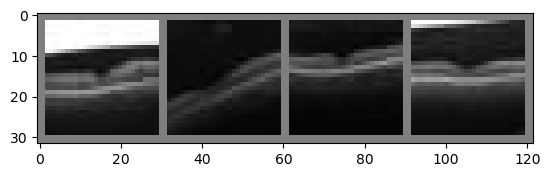

    3     3     3     3


In [3]:
import matplotlib.pyplot as plt
import numpy as np

def imshow(img):
    img = img / 2 + 0.5  # Unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)), cmap='gray')  # Display grayscale images
    plt.show()

# Get some random training images
dataiter = iter(train_loader)
images, labels = next(dataiter)

# Show images
imshow(torchvision.utils.make_grid(images))

# Print labels (OCTMNIST dataset has numerical labels by default)
print(' '.join(f'{labels[j].item():5d}' for j in range(batch_size)))

### Build a neural network

In [4]:
import torch.nn as nn
import torch.nn.functional as F

class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        # First CNN Layer : 1 input channel, 32 output channels, 3x3 kernel
        self.conv1 = nn.Conv2d(1, 32, 3, padding=1)  
        # Second CNN Layer : 32 input channels, 64 output channels, 3x3 kernel
        self.conv2 = nn.Conv2d(32, 64, 3, padding=1)  
        # FNN Layer 1 : 64 channels, 7x7 image size after pooling
        self.fc1 = nn.Linear(64 * 7 * 7, 128)  
        # FNN Layer 2 : 128 input features, 4 output features (classes)
        self.fc2 = nn.Linear(128, 4)  

    def forward(self, x):
        x = self.conv1(x)
        x = F.relu(x)
        x = F.max_pool2d(x, 2)
        x = self.conv2(x)
        x = F.relu(x)
        x = F.max_pool2d(x, 2)
        x = x.view(-1, 64 * 7 * 7)
        x = self.fc1(x)
        x = F.relu(x)
        x = self.fc2(x)
        return x

model = CNN()

### Droupout Layers

In [6]:
class SimpleCNNWithDropout(nn.Module):
    def __init__(self):
        super(SimpleCNNWithDropout, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, 3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, 3, padding=1)
        self.fc1 = nn.Linear(64 * 7 * 7, 128)
        # Adding a dropout layer with probablity 0.5
        self.dropout = nn.Dropout(0.5)  
        self.fc2 = nn.Linear(128, 4)

    def forward(self, x):
        x = self.conv1(x)
        x = F.relu(x)
        x = F.max_pool2d(x, 2)
        x = self.conv2(x)
        x = F.relu(x)
        x = F.max_pool2d(x, 2)
        x = x.view(-1, 64 * 7 * 7)
        x = self.fc1(x)
        x = F.relu(x)
        x = self.dropout(x)  
        x = self.fc2(x)
        return x

model = SimpleCNNWithDropout()

### Early Stopping

In [7]:
class EarlyStopping:
    def __init__(self, patience=5, delta=0):
        self.patience = patience
        self.delta = delta
        self.counter = 0
        self.best_loss = None
        self.early_stop = False

    def __call__(self, val_loss):
        if self.best_loss is None:
            self.best_loss = val_loss
        elif val_loss > self.best_loss + self.delta:
            self.counter += 1
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_loss = val_loss
            self.counter = 0

early_stopping = EarlyStopping(patience=5, delta=0.01)

### Defining the loss functioan and optimizer for model

In [8]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9, weight_decay=0.01)
early_stopping = EarlyStopping(patience=5, delta=0.01)

### Training the model with Early stopping

In [9]:
num_epochs = 10
best_val_loss = float('inf')
train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    correct_train = 0
    total_train = 0

    for i, data in enumerate(train_loader, 0):
        inputs, labels = data
        labels = labels.squeeze().long() 
        if labels.dim() == 0: 
            labels = labels.unsqueeze(0)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

        _, predicted = torch.max(outputs.data, 1)
        total_train += labels.size(0)
        correct_train += (predicted == labels).sum().item()

    train_loss = running_loss / len(train_loader)
    train_accuracy = 100 * correct_train / total_train
    train_losses.append(train_loss)
    train_accuracies.append(train_accuracy)

    model.eval()
    val_loss = 0.0
    correct_val = 0
    total_val = 0

    with torch.no_grad():
        for data in val_loader:
            inputs, labels = data
            labels = labels.squeeze().long()  
            if labels.dim() == 0:  
                labels = labels.unsqueeze(0)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            val_loss += loss.item()

            _, predicted = torch.max(outputs.data, 1)
            total_val += labels.size(0)
            correct_val += (predicted == labels).sum().item()

    val_loss /= len(val_loader)
    val_accuracy = 100 * correct_val / total_val
    val_losses.append(val_loss)
    val_accuracies.append(val_accuracy)

    print(f'Epoch {epoch+1}, Training Loss: {train_loss:.4f}, Validation Loss: {val_loss:.4f}, Training Accuracy: {train_accuracy:.2f}%, Validation Accuracy: {val_accuracy:.2f}%')

    early_stopping(val_loss)
    if early_stopping.early_stop:
        print("Early stopping")
        break

    if val_loss < best_val_loss:
        best_val_loss = val_loss
        torch.save(model.state_dict(), 'best_model.pth')

print('Finished Training')

Epoch 1, Training Loss: 0.9387, Validation Loss: 0.7174, Training Accuracy: 63.36%, Validation Accuracy: 74.84%
Epoch 2, Training Loss: 0.7021, Validation Loss: 0.6068, Training Accuracy: 75.54%, Validation Accuracy: 79.23%
Epoch 3, Training Loss: 0.6177, Validation Loss: 0.5882, Training Accuracy: 78.94%, Validation Accuracy: 79.77%
Epoch 4, Training Loss: 0.5973, Validation Loss: 0.5881, Training Accuracy: 79.69%, Validation Accuracy: 78.87%
Epoch 5, Training Loss: 0.5897, Validation Loss: 0.5750, Training Accuracy: 79.89%, Validation Accuracy: 80.25%
Epoch 6, Training Loss: 0.5833, Validation Loss: 0.5569, Training Accuracy: 80.15%, Validation Accuracy: 81.66%
Epoch 7, Training Loss: 0.5804, Validation Loss: 0.5577, Training Accuracy: 80.21%, Validation Accuracy: 80.57%
Epoch 8, Training Loss: 0.5753, Validation Loss: 0.6260, Training Accuracy: 80.43%, Validation Accuracy: 78.01%
Epoch 9, Training Loss: 0.5737, Validation Loss: 0.5428, Training Accuracy: 80.51%, Validation Accuracy:

 ### Plotting the Training and Validation Accuracies over epochs

Text(0.5, 1.0, 'Training and Validation Accuracy')

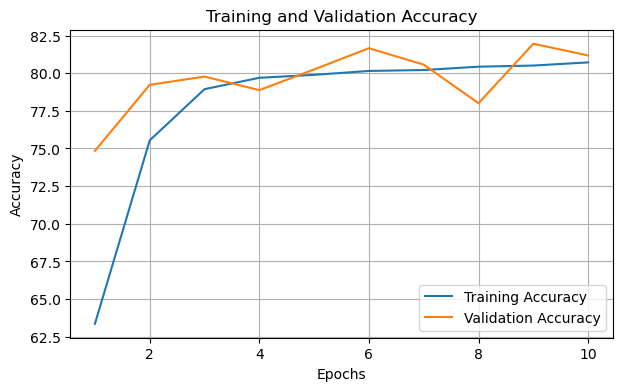

In [25]:
plt.figure(figsize=(7, 4))
plt.plot(range(1, num_epochs+1), train_accuracies, label='Training Accuracy')
plt.plot(range(1, num_epochs+1), val_accuracies, label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.grid()
plt.legend()
plt.title('Training and Validation Accuracy')


### Plot training and validation loss over epochs

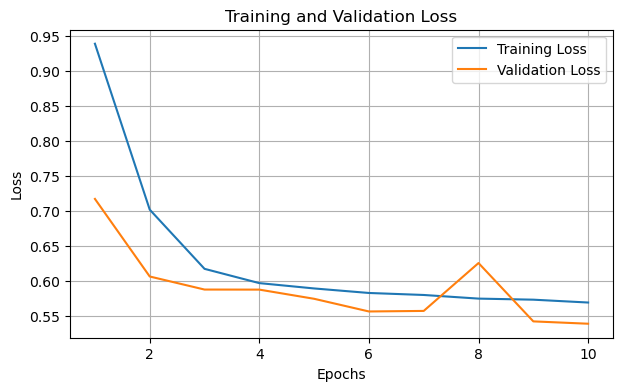

In [26]:
plt.figure(figsize=(7, 4))
plt.plot(range(1, num_epochs+1), train_losses, label='Training Loss')
plt.plot(range(1, num_epochs+1), val_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.grid()
plt.legend()
plt.title('Training and Validation Loss')

plt.show()

### Loading the best model and Plotting the confusion matrix

Test Loss: 0.5330, Test Accuracy: 81.96%


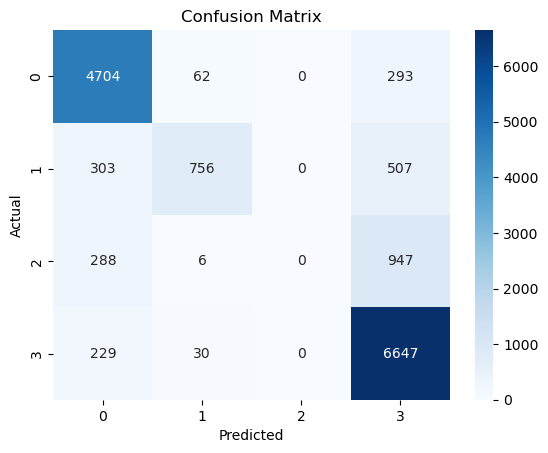

In [14]:
model.load_state_dict(torch.load('best_model.pth'))

model.eval()
test_loss = 0.0
correct_test = 0
total_test = 0
all_preds = []
all_labels = []

with torch.no_grad():
    for data in test_loader:
        inputs, labels = data
        labels = labels.squeeze().long()
        if labels.dim() == 0: 
            labels = labels.unsqueeze(0)
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        test_loss += loss.item()

        # Calculate test accuracy
        _, predicted = torch.max(outputs.data, 1)
        total_test += labels.size(0)
        correct_test += (predicted == labels).sum().item()

        all_preds.extend(predicted.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

test_loss /= len(test_loader)
test_accuracy = 100 * correct_test / total_test

print(f'Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.2f}%')


# Confusion matrix
conf_matrix = confusion_matrix(all_labels, all_preds)
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

### Calculating different Evaluation metrics for analyzing model performance

In [31]:
# Calculate precision, recall, and F1 score
precision, recall, f1, _ = precision_recall_fscore_support(all_labels, all_preds, average='weighted')

print(f'Precision: {precision:.4f}, Recall: {recall:.4f}, F1 Score: {f1:.4f}')

Precision: 0.7557, Recall: 0.8196, F1 Score: 0.7769
